In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data/train.csv")
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2793718,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,N,1040
1,id3485529,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,N,827
2,id1816614,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,N,614
3,id1050851,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,N,867
4,id0140657,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,N,4967


In [66]:
df.drop("id", axis=1, inplace=True)
df.drop("store_and_fwd_flag", axis=1, inplace=True)
df.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
0,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,1040
1,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,827
2,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,614
3,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,867
4,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,4967


In [67]:
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
df["month"] = df["pickup_datetime"].dt.month
df["day"] = df["pickup_datetime"].dt.day
df["hour"] = df["pickup_datetime"].dt.hour
df["weekday_num"] = df["pickup_datetime"].dt.dayofweek
df.drop("pickup_datetime", axis=1, inplace=True)
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,month,day,hour,weekday_num
0,2,1,-73.985611,40.735943,-73.980331,40.760468,1040,6,8,7,2
1,2,1,-73.978394,40.764351,-73.991623,40.749859,827,4,3,12,6
2,2,5,-73.989059,40.744389,-73.973381,40.748692,614,6,5,2,6
3,2,2,-73.990326,40.731136,-73.991264,40.748917,867,5,5,17,3
4,1,4,-73.789497,40.646675,-73.987137,40.759232,4967,5,12,17,3


In [68]:
def haversine_array(lat1, lon1, lat2, lon2):
        R = 6371
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat, dlon = lat2 - lat1, lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        return R * 2 * np.arcsin(np.sqrt(a))

df["trip_distance"] = haversine_array(
            df["pickup_latitude"], df["pickup_longitude"],
            df["dropoff_latitude"], df["dropoff_longitude"])
df.drop("pickup_latitude", axis=1, inplace=True)
df.drop("pickup_longitude", axis=1, inplace=True)
df.drop("dropoff_latitude", axis=1, inplace=True)
df.drop("dropoff_longitude", axis=1, inplace=True)
df.head()

,vendor_id,passenger_count,trip_duration,month,day,hour,weekday_num,trip_distance
0,2,1,1040,6,8,7,2,2.763050
1,2,1,827,4,3,12,6,1.959178
2,2,5,614,6,5,2,6,1.404772
3,2,2,867,5,5,17,3,1.978660
4,1,4,4967,5,12,17,3,20.837745


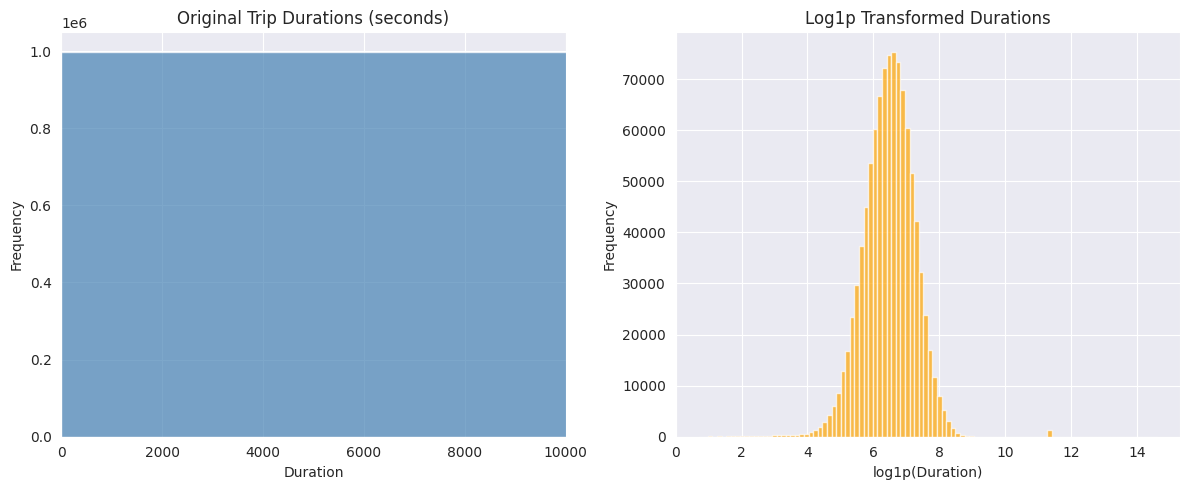

In [69]:
# Trip durations (target variable)
durations = df["trip_duration"].values

# Apply log1p transformation
log_durations = np.log1p(durations)

# Plot distributions
plt.figure(figsize=(12,5))

# Original distribution
plt.subplot(1,2,1)
plt.hist(durations, bins=100, color='steelblue', alpha=0.7)
plt.title("Original Trip Durations (seconds)")
plt.xlabel("Duration")
plt.ylabel("Frequency")
plt.xlim(0, 10000)  # optional: to zoom in and ignore extreme outliers

# Transformed distribution
plt.subplot(1,2,2)
plt.hist(log_durations, bins=100, color='orange', alpha=0.7)
plt.title("Log1p Transformed Durations")
plt.xlabel("log1p(Duration)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [70]:
# تعويض القيم المفقودة
df = df.fillna(df.mean(numeric_only=True))

# تصفية الرحلات الغير منطقية
df = df[(df['trip_duration'] > (3*60)) & (df['trip_duration'] < (130*60))]   # بين 3 دقائق و 130 دقيقة
df = df[(df["trip_distance"] >= 0.03) & (df["trip_distance"] <= 100)]   # مسافة منطقية
df["trip_duration"] = np.log1p(df["trip_duration"])

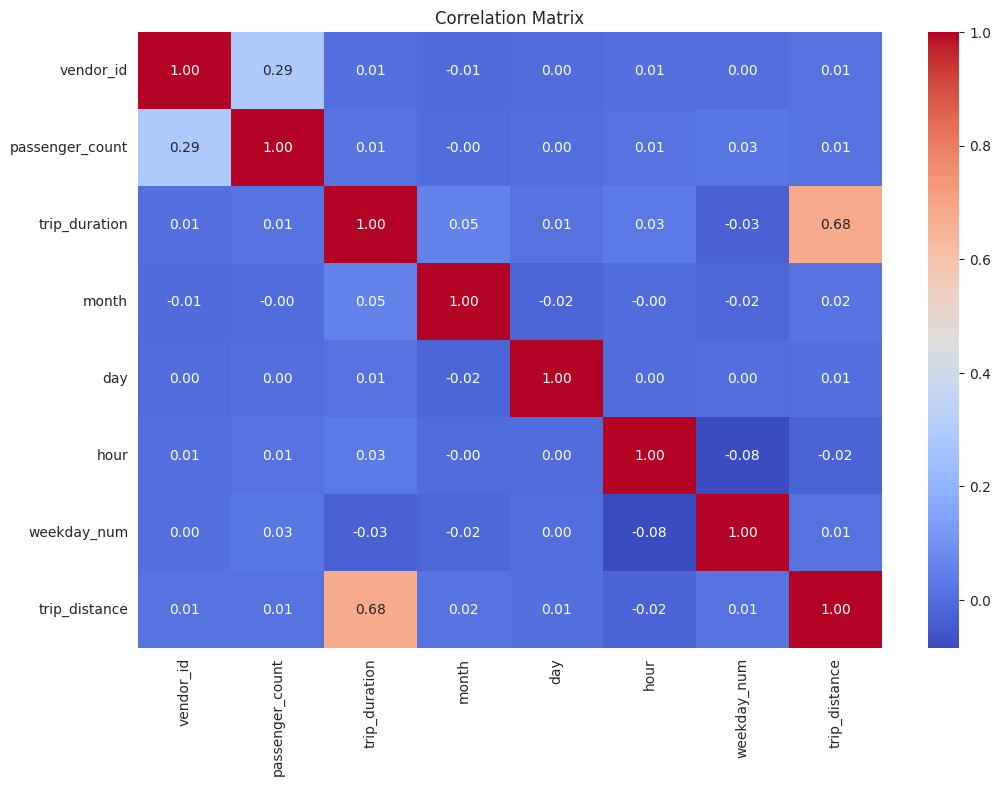

In [71]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

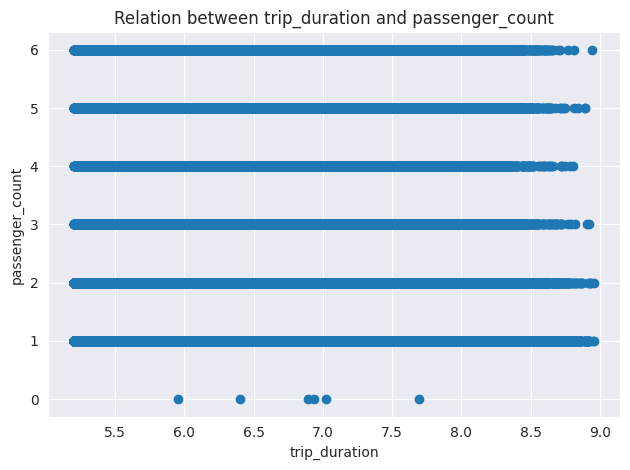

In [72]:
plt.scatter(df["trip_duration"], df["passenger_count"])
plt.xlabel("trip_duration")
plt.ylabel("passenger_count")
plt.title("Relation between trip_duration and passenger_count")
plt.tight_layout()
plt.show()

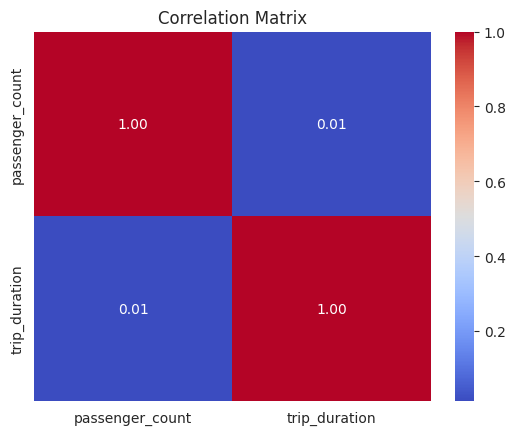

In [73]:
corr = df[["passenger_count", "trip_duration"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [74]:
df.drop("passenger_count", axis=1, inplace=True)
df.head()

,vendor_id,trip_duration,month,day,hour,weekday_num,trip_distance
0,2,6.947937,6,8,7,2,2.763050
1,2,6.719013,4,3,12,6,1.959178
2,2,6.421622,6,5,2,6,1.404772
3,2,6.766192,5,5,17,3,1.978660
4,1,8.510773,5,12,17,3,20.837745


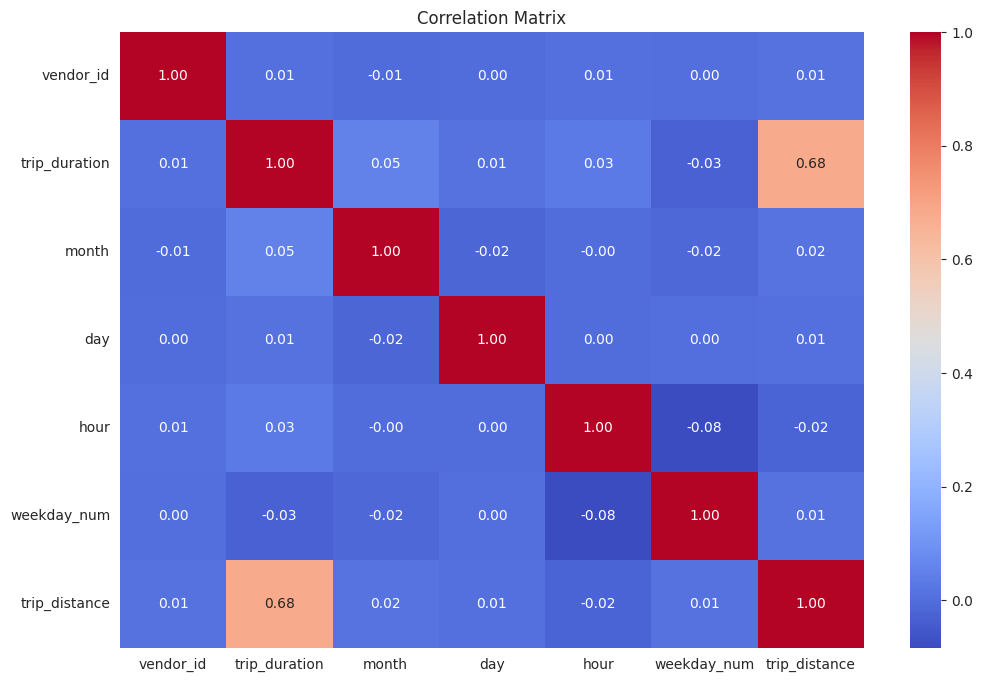

In [75]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [76]:
df.drop("month", axis=1, inplace=True)
df.drop("day", axis=1, inplace=True)
df.drop("hour", axis=1, inplace=True)
df.drop("vendor_id", axis=1, inplace=True)
df.drop("weekday_num", axis=1, inplace=True)
df.head()

,trip_duration,trip_distance
0,6.947937,2.763050
1,6.719013,1.959178
2,6.421622,1.404772
3,6.766192,1.978660
4,8.510773,20.837745


In [77]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler



# تحديد الهدف (y) والمتغيرات (X)
y_train = df["trip_duration"]
X_train = df.drop("trip_duration", axis=1)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# تدريب Ridge Regression
model = Ridge(alpha=1)
model.fit(X_train, y_train)


,alpha,1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [79]:
from sklearn.metrics import r2_score, mean_squared_error
dfv = pd.read_csv("/home/mohamed-othman/PycharmProjects/Taxi Trip Duration Prediction/data/val.csv")
def haversine_array(lat1, lon1, lat2, lon2):
        R = 6371
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat, dlon = lat2 - lat1, lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        return R * 2 * np.arcsin(np.sqrt(a))

dfv["trip_distance"] = haversine_array(
            dfv["pickup_latitude"], dfv["pickup_longitude"],
            dfv["dropoff_latitude"], dfv["dropoff_longitude"])
dfv["pickup_datetime"] = pd.to_datetime(dfv["pickup_datetime"])
dfv["weekday_num"] = dfv["pickup_datetime"].dt.dayofweek

dfv.fillna(dfv.mean(numeric_only=True))
dfv = dfv[(dfv['trip_duration'] > 3*60) & (dfv['trip_duration'] < 130*60)]

# تنظيف trip_distance
dfv = dfv[(dfv["trip_distance"] >= 0.03) & (dfv["trip_distance"] <= 100)]
y_val = dfv["trip_duration"]
y_val = np.log1p(y_val)

x_val = dfv[["trip_distance"]]
x_val = scaler.fit_transform(x_val)

y_predict = model.predict(x_val)

r2_score(y_val, y_predict)


0.4640480148253988